In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import statsmodels.api as sm
from scipy import stats
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import random


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# plt.rcParams['figure.figsize'] = (10, 5)
# plt.style.use('fivethirtyeight')

# Code for data extraction
1. In this section we will load the raw data and extract utilization and frequency value

In [4]:
utilData = pd.read_csv('./Util_Run1.csv')
utilData.shape

(2674, 6)

In [5]:
utilData.head()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq
0,604872,4612865,165000000,0,31,600000
1,675,28712,275000000,0,4,200000
2,1191888,12624777,413000000,0,8,200000
3,773492,8196989,275000000,0,9,300000
4,1144,57890,206000000,0,7,300000


In [6]:
utilData['memLoad'] = utilData['memUse']*100/utilData['memTot']
utilData['memScore'] = utilData['memLoad']*utilData['memfreq']/825000000
utilData['memF'] = utilData['memfreq']*100/825000000

In [7]:
utilData['cpuScore'] = utilData['cpuload']*utilData['cpufreq']/1400000
utilData['cpuF'] = utilData['cpufreq']*100/1000000
utilData['memShift'] = utilData['memLoad'].shift()

In [8]:
utilData.head()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,memScore,memF,cpuScore,cpuF,memShift
0,604872,4612865,165000000,0,31,600000,13.112718,2.622544,20.000000,13.285714,60.0,NaN
1,675,28712,275000000,0,4,200000,2.350933,0.783644,33.333333,0.571429,20.0,13.112718
2,1191888,12624777,413000000,0,8,200000,9.440864,4.726154,50.060606,1.142857,20.0,2.350933
3,773492,8196989,275000000,0,9,300000,9.436294,3.145431,33.333333,1.928571,30.0,9.440864
4,1144,57890,206000000,0,7,300000,1.976162,0.493442,24.969697,1.500000,30.0,9.436294


In [9]:
tot_train = utilData.iloc[0:2136]


In [10]:
train_1 = utilData.iloc[0:534]
train_2 = utilData.iloc[534:1068]
train_3 = utilData.iloc[1068:1602]
train_4 = utilData.iloc[1602:2136]
test_data = utilData.iloc[2136:]
print(train_1.tail())
test_data.shape

      memUse   memTot    memfreq  cpuid  cpuload  cpufreq    memLoad  \
529    41341   464426  825000000      0       50   800000   8.901526   
530    41341   464426  825000000      0       33   600000   8.901526   
531    41341   464426  825000000      0       30   600000   8.901526   
532    41341   464426  825000000      0       29   500000   8.901526   
533  2457799  3939455  825000000      0       40   700000  62.389315   

      memScore   memF   cpuScore  cpuF   memShift  
529   8.901526  100.0  28.571429  80.0  18.210879  
530   8.901526  100.0  14.142857  60.0   8.901526  
531   8.901526  100.0  12.857143  60.0   8.901526  
532   8.901526  100.0  10.357143  50.0   8.901526  
533  62.389315  100.0  20.000000  70.0   8.901526  


(538, 12)

In [11]:
# Sample Space to experiment

# Modeling 
In this section we will model the data and test its accuracy

In [12]:
utilData['memShift'] = utilData['memLoad'].shift()

In [13]:
model = ARIMA(tot_train[['cpuF']], order=(3,2,1), exog=tot_train[['memLoad','cpuScore']])
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                 2136
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -7096.125
Date:                Thu, 14 Sep 2023   AIC                          14206.251
Time:                        10:57:22   BIC                          14245.911
Sample:                             0   HQIC                         14220.766
                               - 2136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
memLoad        0.0659      0.015      4.432      0.000       0.037       0.095
cpuScore       1.0906      0.010    109.535      0.000       1.071       1.110
ar.L1         -0.6111      0.013    -45.839      0.0

In [14]:
model1 = ARIMA(train_1['cpuF'], order=(2,0,0))
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2067.064
Date:                Thu, 14 Sep 2023   AIC                           4142.129
Time:                        10:57:22   BIC                           4159.250
Sample:                             0   HQIC                          4148.828
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.0776      6.064      6.609      0.000      28.193      51.962
ar.L1          0.5687      0.019     30.441      0.000       0.532       0.605
ar.L2          0.3259      0.023     13.962      0.0

In [15]:
model2 = ARIMA(train_2['cpuF'], order=(2,0,1), exog=train_2['cpuScore'])
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1599.439
Date:                Thu, 14 Sep 2023   AIC                           3210.877
Time:                        10:57:23   BIC                           3236.559
Sample:                             0   HQIC                          3220.926
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7742      0.442    112.602      0.000      48.908      50.641
cpuScore       0.9393      0.011     88.506      0.000       0.919       0.960
ar.L1          0.5820      0.275      2.114      0.0

In [16]:
model3 = ARIMA(train_3['cpuF'], order=(2,0,1), exog=train_3['cpuScore'])
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1787.734
Date:                Thu, 14 Sep 2023   AIC                           3587.468
Time:                        10:57:23   BIC                           3613.150
Sample:                             0   HQIC                          3597.517
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2394      3.346     10.530      0.000      28.680      41.798
cpuScore       1.0555      0.021     49.487      0.000       1.014       1.097
ar.L1          1.0417      0.053     19.770      0.0

In [17]:
model4 = ARIMA(train_4['cpuF'], order=(4,0,1), exog=train_4['cpuScore'])
result4 = model4.fit()
print(result4.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1814.247
Date:                Thu, 14 Sep 2023   AIC                           3644.493
Time:                        10:57:23   BIC                           3678.737
Sample:                             0   HQIC                          3657.892
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2761      0.855     35.424      0.000      28.601      31.951
cpuScore       1.1431      0.023     49.682      0.000       1.098       1.188
ar.L1         -0.0924      0.406     -0.227      0.8

## Testing Accuracy
We will run both the models to test its accuracy

In [18]:
# This is to test the accuracy of prediction
from sklearn import metrics

In [19]:
forecast = result.forecast(steps=538,exog=test_data[['memScore','cpuScore']])
forecast = forecast.to_numpy()

In [20]:
mtest_data = test_data.iloc[0:20]
pforecast = result.get_forecast(steps=20,exog=mtest_data[['memScore','cpuScore']])

In [21]:
myDf = pforecast.summary_frame(alpha=0.05)
myDf['memScore'] = mtest_data['memScore'].values
myDf['cpuScore'] = mtest_data['cpuScore'].values
myDf['Actual freq'] = mtest_data['cpuF'].values
myDf


cpuF,mean,mean_se,mean_ci_lower,mean_ci_upper,memScore,cpuScore,Actual freq
2136,123.838428,6.715562,110.676168,137.000688,0.458928,85.428571,130.0
2137,122.097688,7.206788,107.972642,136.222733,4.550155,83.571429,130.0
2138,120.164932,7.749568,104.976058,135.353805,6.023547,81.714286,130.0
2139,123.289913,8.236803,107.146076,139.433749,6.582994,84.500000,130.0
2140,140.062902,8.968700,122.484573,157.641230,5.078400,100.000000,140.0
2141,140.065994,9.477298,121.490831,158.641158,5.078400,100.000000,140.0
2142,137.607548,9.976890,118.053203,157.161894,0.895113,98.000000,140.0
2143,124.048781,10.448693,103.569719,144.527842,3.125317,85.428571,130.0
2144,111.723985,10.925267,90.310855,133.137115,10.039009,73.714286,120.0
2145,123.887469,11.366235,101.610059,146.164879,16.106359,84.500000,130.0


In [22]:
mtest_data = test_data.iloc[300:320]
pforecast = result.get_forecast(steps=20,exog=mtest_data[['memScore','cpuScore']])
myDf = pforecast.summary_frame(alpha=0.05)
myDf['memScore'] = mtest_data['memScore'].values
myDf['cpuScore'] = mtest_data['cpuScore'].values
myDf['Actual freq'] = mtest_data['cpuF'].values
myDf

cpuF,mean,mean_se,mean_ci_lower,mean_ci_upper,memScore,cpuScore,Actual freq
2136,31.515610,6.715562,18.353350,44.677871,1.532227,0.714286,20.0
2137,31.675579,7.206788,17.550533,45.800625,1.366319,0.857143,20.0
2138,32.567481,7.749568,17.378608,47.756355,4.327118,1.500000,30.0
2139,31.837460,8.236803,15.693624,47.981297,3.132153,0.857143,30.0
2140,32.264543,8.968700,14.686215,49.842872,3.019357,1.285714,30.0
2141,31.800215,9.477298,13.225052,50.375378,3.019357,0.857143,30.0
2142,32.499920,9.976890,12.945574,52.054266,3.019357,1.500000,30.0
2143,32.271466,10.448693,11.792404,52.750527,3.019357,1.285714,30.0
2144,31.643934,10.925267,10.230804,53.057064,3.019357,0.714286,20.0
2145,51.472925,11.366235,29.195515,73.750335,13.102382,18.285714,80.0


In [23]:
forecast1 = result1.forecast(steps=538)
forecast1 = forecast1.to_numpy()

In [24]:
forecast2 = result2.forecast(steps=538,exog=test_data['cpuScore'])
forecast2 = forecast2.to_numpy()

In [25]:
forecast3 = result3.forecast(steps=538,exog=test_data['cpuScore'])
forecast3 = forecast3.to_numpy()

In [26]:
forecast4 = result4.forecast(steps=538,exog=test_data['cpuScore'])
forecast4 = forecast4.to_numpy()

In [27]:
y_true = test_data['cpuF'].to_numpy()

In [28]:
print('RMSE', np.sqrt(metrics.mean_squared_error(y_true,forecast)))

RMSE 7.009868110602993


In [29]:
print('RMSE_1', np.sqrt(metrics.mean_squared_error(y_true,forecast1)))

RMSE_1 54.21645372844092


In [30]:
print('RMSE_2', np.sqrt(metrics.mean_squared_error(y_true,forecast2)))

RMSE_2 18.383397917008732


In [31]:
print('RMSE_3', np.sqrt(metrics.mean_squared_error(y_true,forecast3)))

RMSE_3 8.81518286361453


In [32]:
print('RMSE_4', np.sqrt(metrics.mean_squared_error(y_true,forecast4)))

RMSE_4 6.822845766686316


# Splitting the time series
1. We will split the time series in fragments of 25 entries and then create 4 different entries and merge to train the data

In [33]:
strain_1 = utilData.iloc[0:25]
strain_2 = utilData.iloc[25:50]
strain_3 = utilData.iloc[50:75]
strain_4 = utilData.iloc[75:100]
stest_data = utilData.iloc[2200:]
stest_data.shape

(474, 12)

In [34]:
strain_1.tail()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,memScore,memF,cpuScore,cpuF,memShift
20,731460,7728405,275000000,0,11,300000,9.464566,3.154855,33.333333,2.357143,30.0,2.357262
21,731460,7728405,275000000,0,10,300000,9.464566,3.154855,33.333333,2.142857,30.0,9.464566
22,731460,7728405,275000000,0,12,300000,9.464566,3.154855,33.333333,2.571429,30.0,9.464566
23,731460,7728405,275000000,0,11,300000,9.464566,3.154855,33.333333,2.357143,30.0,9.464566
24,731460,7728405,275000000,0,9,300000,9.464566,3.154855,33.333333,1.928571,30.0,9.464566


In [35]:
# We create our data here
for i in range(100,2136,100):
    i_1,i_2,i_3,i_4 = i,i+25,i+50,i+75
    i_end = i+100
    strain_1 = strain_1.append(utilData.iloc[i_1:i_2],ignore_index=True)
    strain_2 = strain_2.append(utilData.iloc[i_2:i_3],ignore_index=True)
    strain_3 = strain_3.append(utilData.iloc[i_3:i_4],ignore_index=True)
    strain_4 = strain_4.append(utilData.iloc[i_4:i_end],ignore_index=True)

In [36]:
strain_4.shape

(550, 12)

## Modeling the split time series
We are using the newly generated split dataset to train and verify its acuracy

In [37]:
smodel1 = ARIMA(strain_1['cpuScore'], order=(4,0,3), exog=strain_1['cpuF'])
sresult1 = smodel1.fit()
print(sresult1.summary())

                               SARIMAX Results                                
Dep. Variable:               cpuScore   No. Observations:                  550
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -1687.915
Date:                Thu, 14 Sep 2023   AIC                           3395.829
Time:                        10:57:24   BIC                           3438.929
Sample:                             0   HQIC                          3412.672
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.3049      1.538    -15.807      0.000     -27.318     -21.291
cpuF           0.7901      0.008     96.672      0.000       0.774       0.806
ar.L1         -0.0441      0.121     -0.365      0.7

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
smodel2 = ARIMA(strain_2['cpuF'], order=(4,0,1))
sresult2 = smodel2.fit()
print(sresult2.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -2266.101
Date:                Thu, 14 Sep 2023   AIC                           4546.202
Time:                        10:57:24   BIC                           4576.372
Sample:                             0   HQIC                          4557.992
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2209     13.615      4.350      0.000      32.536      85.906
ar.L1          0.4721      1.007      0.469      0.639      -1.501       2.445
ar.L2          0.3200      0.692      0.462      0.6

In [39]:
smodel3 = ARIMA(strain_3['cpuF'], order=(4,0,1), exog=strain_3['cpuScore'])
sresult3 = smodel3.fit()
print(sresult3.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1873.463
Date:                Thu, 14 Sep 2023   AIC                           3762.926
Time:                        10:57:25   BIC                           3797.406
Sample:                             0   HQIC                          3776.400
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.8708      3.170     11.000      0.000      28.657      41.084
cpuScore       1.0762      0.022     49.627      0.000       1.034       1.119
ar.L1          1.0832      0.057     18.881      0.0

In [40]:
smodel4 = ARIMA(strain_4['cpuF'], order=(4,0,1), exog=strain_4['cpuScore'])
sresult4 = smodel4.fit()
print(sresult4.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1827.922
Date:                Thu, 14 Sep 2023   AIC                           3671.845
Time:                        10:57:25   BIC                           3706.324
Sample:                             0   HQIC                          3685.319
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.9780      1.572     22.249      0.000      31.897      38.059
cpuScore       1.1037      0.026     41.984      0.000       1.052       1.155
ar.L1          0.2633      0.227      1.162      0.2

## Prediction Phase for split
We are calculating the RMSE of the models

In [41]:
sforecast1 = sresult1.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast1 = sforecast1.to_numpy()

In [42]:
sy_true = stest_data['cpuF'].to_numpy()

In [43]:
print('RMSE_1', np.sqrt(metrics.mean_squared_error(sy_true,sforecast1)))

RMSE_1 62.662810102676545


In [44]:
sforecast2 = sresult2.forecast(steps=474)
sforecast2 = sforecast2.to_numpy()

In [45]:
print('RMSE_2', np.sqrt(metrics.mean_squared_error(sy_true,sforecast2)))

RMSE_2 40.92977941406103


In [46]:
sforecast3 = sresult3.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast3 = sforecast3.to_numpy()

In [47]:
print('RMSE_3', np.sqrt(metrics.mean_squared_error(sy_true,sforecast3)))

RMSE_3 8.776175068204283


In [48]:
sforecast4 = sresult4.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast4 = sforecast4.to_numpy()

In [49]:
print('RMSE_4', np.sqrt(metrics.mean_squared_error(sy_true,sforecast4)))

RMSE_4 8.90310195384028


### Note; the results are better for smaller prediction interval. 
Does it mean we need to retrain every small interval. (We did 100 v. 474)
That is not an effective prediction model

# Grouping the data by a column
We will now model for each state of the cpufrequency

In [50]:
#Get the unique cpuF values
cpuFArr = tot_train['cpuF'].unique()
cpuFArr

array([ 60.,  20.,  30.,  40.,  50., 120.,  70.,  80., 140., 130., 100.,
        90., 110.])

In [51]:
sorted(utilData['memfreq'].unique())

[165000000, 206000000, 275000000, 413000000, 543000000, 825000000]

In [52]:
gtrain = tot_train.groupby(['cpuF'])

In [53]:
gtrain.get_group(cpuFArr[0])

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,memScore,memF,cpuScore,cpuF,memShift
0,604872,4612865,165000000,0,31,600000,13.112718,2.622544,20.000000,13.285714,60.0,NaN
12,3742,166275,275000000,0,31,600000,2.250489,0.750163,33.333333,13.285714,60.0,4.441404
13,3742,166275,275000000,0,40,600000,2.250489,0.750163,33.333333,17.142857,60.0,2.250489
32,709011,7717381,275000000,0,13,600000,9.187197,3.062399,33.333333,5.571429,60.0,9.187197
60,1228,46513,275000000,0,30,600000,2.640122,0.880041,33.333333,12.857143,60.0,2.640122
...,...,...,...,...,...,...,...,...,...,...,...,...
1934,7212,180508,825000000,0,32,600000,3.995391,3.995391,100.000000,13.714286,60.0,3.332219
1948,845096,15828949,543000000,0,31,600000,5.338927,3.513985,65.818182,13.285714,60.0,34.173306
1955,912556,14908785,413000000,0,36,600000,6.120928,3.064174,50.060606,15.428571,60.0,5.942246
1977,37665,206049,543000000,0,47,600000,18.279633,12.031322,65.818182,20.142857,60.0,25.887428


In [54]:
mapTrain = {}
for  val in cpuFArr:
    mapTrain[val] = gtrain.get_group(val)

In [55]:
gresult ={}
for val in cpuFArr:
    print("\n\nVal",val)
    gmodel = ARIMA(mapTrain[val]['cpuload'], order=(1,0,1))
    gresult[val] = gmodel.fit()
    print(gresult[val].summary())



Val 60.0
                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  198
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -620.984
Date:                Thu, 14 Sep 2023   AIC                           1249.968
Time:                        10:57:25   BIC                           1263.121
Sample:                             0   HQIC                          1255.292
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9655      0.808     40.778      0.000      31.381      34.550
ar.L1          0.7387      0.150      4.939      0.000       0.446       1.032
ma.L1         -0.5437      0.179     -3.0

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported inde

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  823
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1973.630
Date:                Thu, 14 Sep 2023   AIC                           3955.261
Time:                        10:57:25   BIC                           3974.113
Sample:                             0   HQIC                          3962.493
                                - 823                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5444      0.520     18.346      0.000       8.525      10.564
ar.L1          0.9524      0.017     55.387      0.000       0.919       0.986
ma.L1         -0.7706      0.028    -27.301      0.0

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                   96
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -323.785
Date:                Thu, 14 Sep 2023   AIC                            655.571
Time:                        10:57:25   BIC                            665.828
Sample:                             0   HQIC                           659.717
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.3660      1.245     38.864      0.000      45.927      50.805
ar.L1          0.0013      1.788      0.001      0.999      -3.504       3.507
ma.L1         -0.1418      1.770     -0.080      0.9

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                   34
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -134.798
Date:                Thu, 14 Sep 2023   AIC                            277.595
Time:                        10:57:26   BIC                            283.700
Sample:                             0   HQIC                           279.677
                                 - 34                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.7007      8.448      8.724      0.000      57.143      90.258
ar.L1         -0.2678      1.050     -0.255      0.799      -2.327       1.791
ma.L1          0.7383      1.003      0.736      0.4

### The results are very confusing
What should serve as the endogenous and exogenous variable for this model?

# Plotting the data
Understand how does the state looks like with the change


<Axes: >

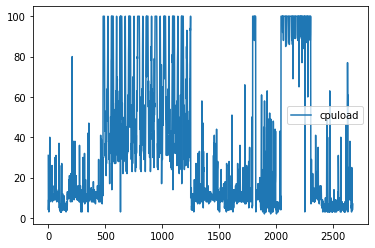

In [56]:
utilData.plot(y='cpuload')

<Axes: >

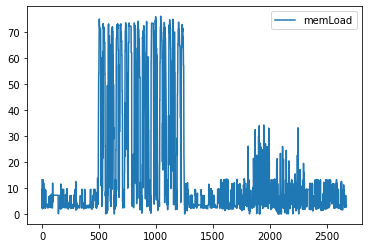

In [57]:
utilData.plot(y='memLoad')

In [58]:
x_axis= utilData.index.values.tolist()

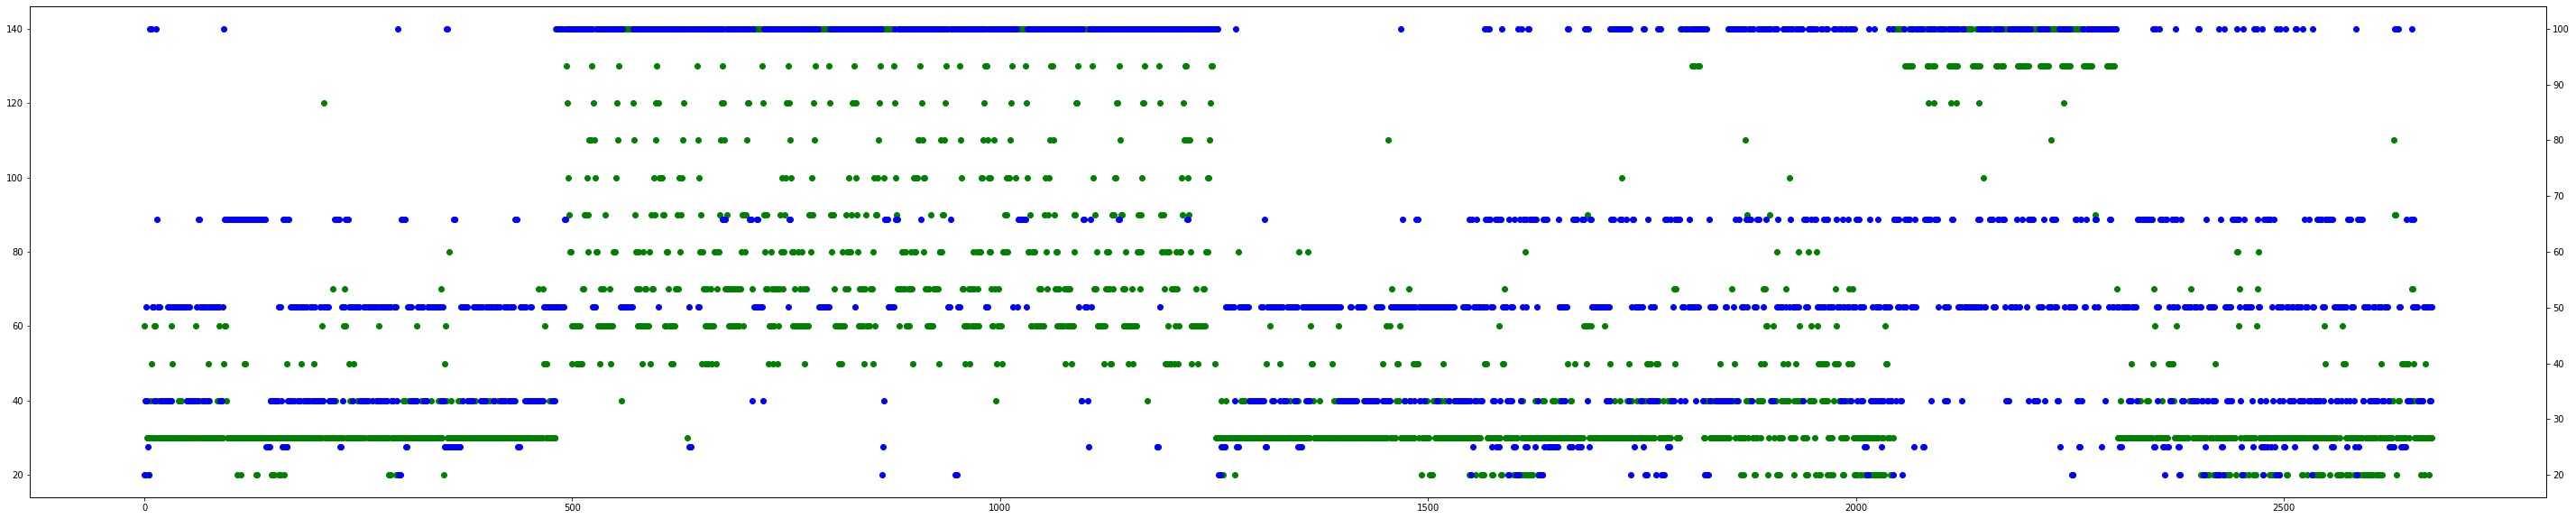

In [59]:
# plt.figure(figsize=(50,2))
fig, ax1 = plt.subplots(figsize=(50, 10))

x = utilData.index.values.tolist()
y1 = utilData['cpuF']
y2 = utilData['memF']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

<Figure size 3600x720 with 0 Axes>

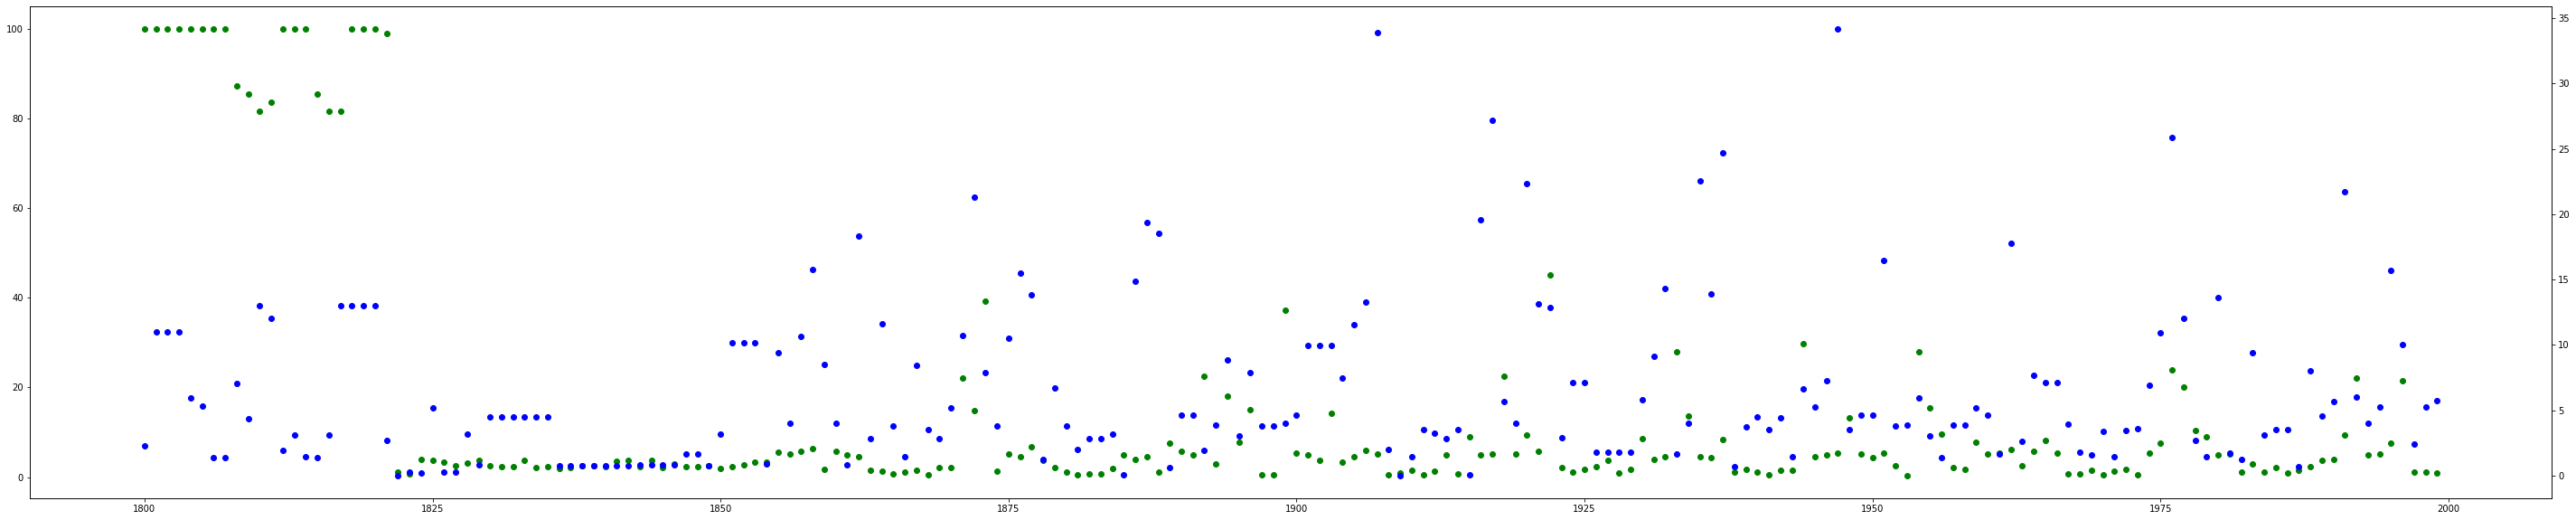

In [60]:
plt.figure(figsize=(50,10))
fig, ax1 = plt.subplots(figsize=(50, 10))

x = utilData[1800:2000].index.values.tolist()
y1 = utilData['cpuScore'].iloc[1800:2000]
y2 = utilData['memScore'].iloc[1800:2000]

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

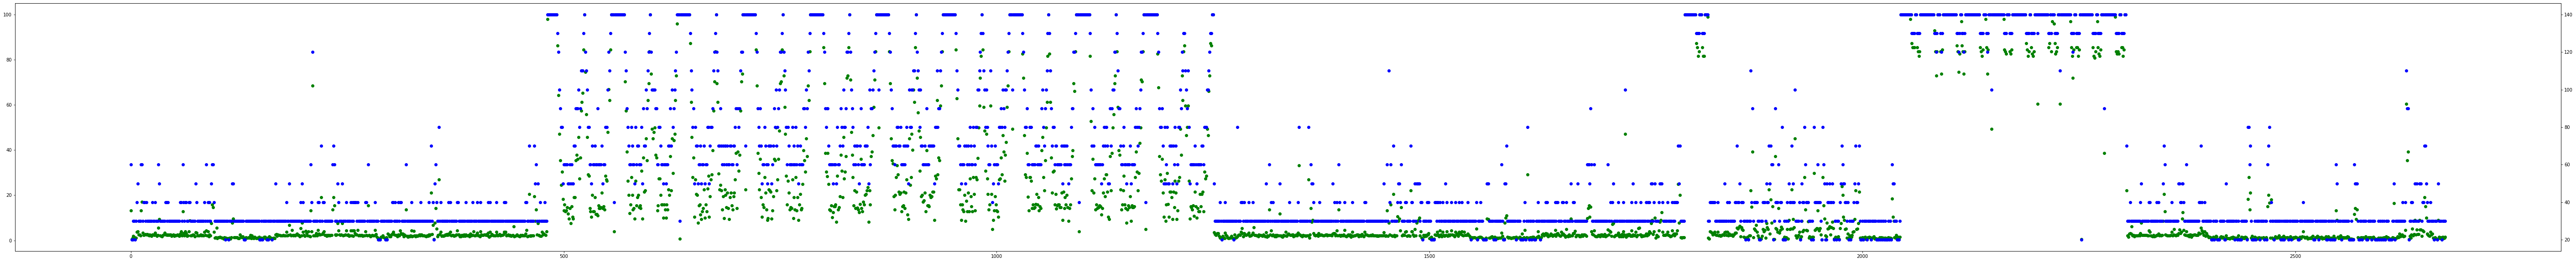

In [61]:
# plt.figure(figsize=(100,40))
fig, ax1 = plt.subplots(figsize=(100,10))

x = utilData.index.values.tolist()
y1 = utilData['cpuScore']
y2 = utilData['cpuF']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

<Figure size 5760x720 with 0 Axes>

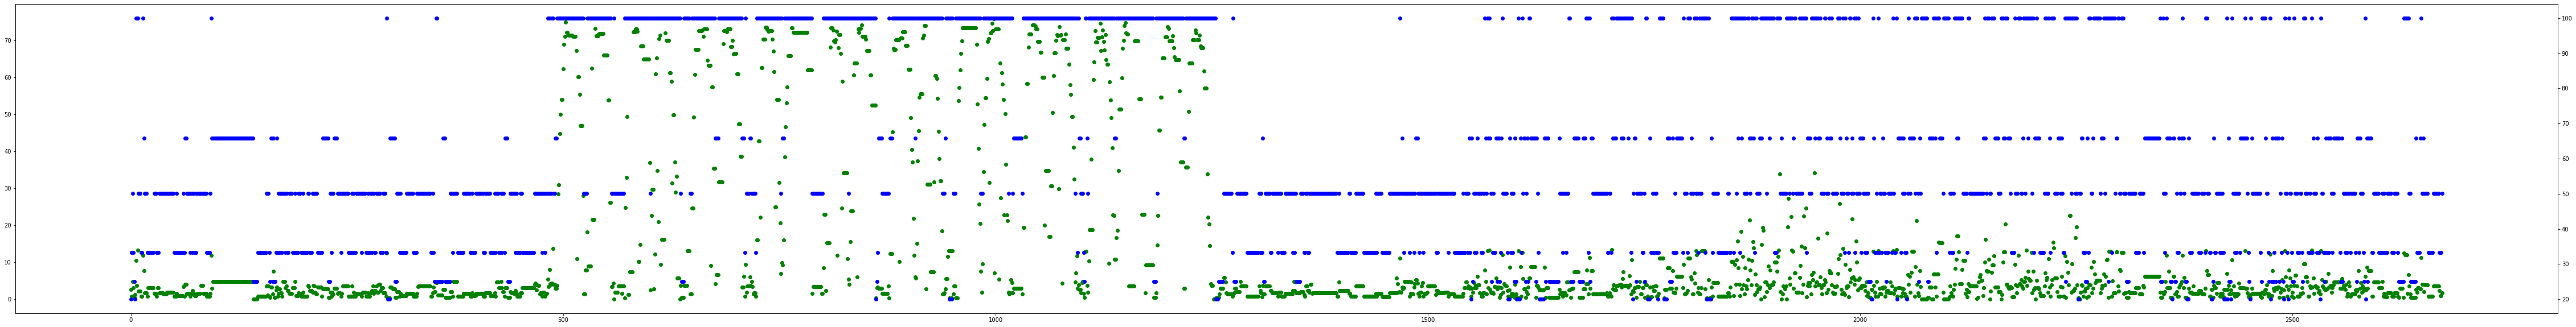

In [62]:
plt.figure(figsize=(80,10))
fig, ax1 = plt.subplots(figsize=(80,10))

x = utilData.index.values.tolist()
y1 = utilData['memScore']
y2 = utilData['memF']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

<Figure size 3600x144 with 0 Axes>

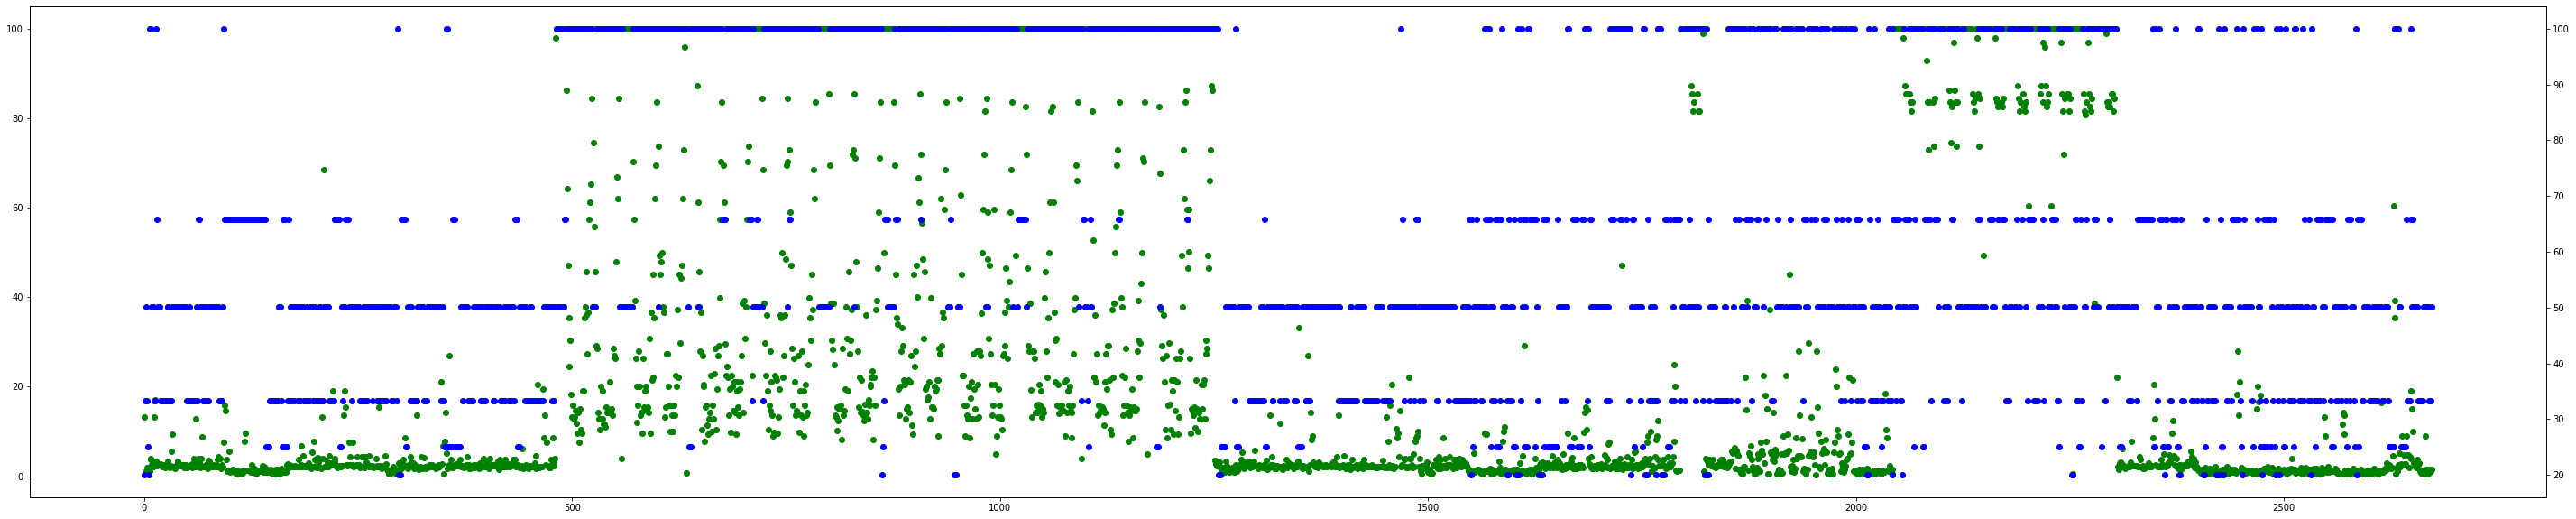

In [63]:
plt.figure(figsize=(50,2))
fig, ax1 = plt.subplots(figsize=(50,10))

x = utilData.index.values.tolist()
y1 = utilData['cpuScore']
y2 = utilData['memF']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

In [64]:
# Empty space for plotting more

# Characterizing state and load behaviour
How does cpuload, memload, and their frequencies fare

In [65]:
def diffCorr(x,y):
    print("Pearson",stats.pearsonr(x,y))
    print("Spearman",stats.spearmanr(x,y))

In [66]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['memfreq'].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.3836347504363804, pvalue=1.7063228385858013e-94)
Spearman SignificanceResult(statistic=0.47070653722998695, pvalue=1.5434514304878583e-147)


In [67]:
x1 = utilData['memLoad'].to_numpy()
x2 = utilData['cpuF'].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.166601935751212, pvalue=4.255277434039913e-18)
Spearman SignificanceResult(statistic=0.3111704705195926, pvalue=4.017215464125179e-61)


In [68]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.9767547511328467, pvalue=0.0)
Spearman SignificanceResult(statistic=0.9563341295204049, pvalue=0.0)


In [69]:
x1 = utilData['memScore'][0:500].to_numpy()
x2 = utilData['cpuScore'][0:500].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.2371348222140171, pvalue=8.05247743413708e-08)
Spearman SignificanceResult(statistic=-0.022169267470536456, pvalue=0.6209249027838075)


In [70]:
x1 = utilData['memfreq'].to_numpy()
x2 = utilData['memLoad'].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.6229270915789488, pvalue=2.867526676189275e-287)
Spearman SignificanceResult(statistic=0.5987098763658174, pvalue=7.37488228744494e-260)


In [71]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['memLoad'].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.166601935751212, pvalue=4.255277434039913e-18)
Spearman SignificanceResult(statistic=0.3111704705195926, pvalue=4.017215464125179e-61)


In [72]:
x1 = utilData['memfreq'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=0.28102522714424977, pvalue=1.0101016102959791e-49)
Spearman SignificanceResult(statistic=0.44547340370761845, pvalue=1.5588595621015236e-130)


In [73]:
x1 = utilData['memF'][500:1000].to_numpy()
x2 = utilData['cpuScore'][500:1000].to_numpy()
diffCorr(x1,x2)

Pearson PearsonRResult(statistic=-0.6501625547573261, pvalue=2.1172362956958752e-61)
Spearman SignificanceResult(statistic=-0.5693636481061536, pvalue=2.658643254534761e-44)


### Note: Memory has more cross resource predictive power but cpu is better at its own prediction
We will utilize these values and try run a linear model to check how the coefficients look for a multi-dimensional ARMA model and a linear/other regression model

In [74]:
#Empty space for code

# Plotting PACF and ACF
We need to find out the level of autocorrelation in the values

In [75]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

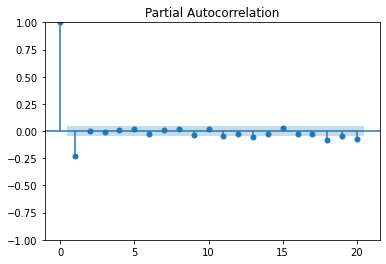

In [76]:
plot_pacf(tot_train['cpuScore'].diff().dropna(), lags=20, alpha=0.05,method='ols');

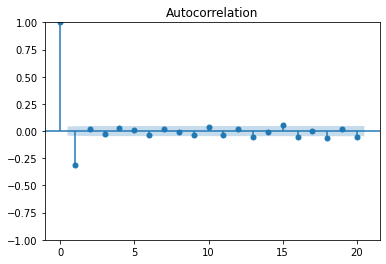

In [77]:
plot_acf(tot_train['cpuload'].diff().dropna(), lags=20, alpha=0.05);

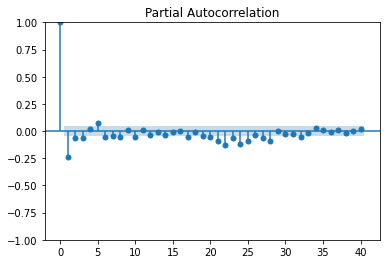

In [78]:
plot_pacf(tot_train['memLoad'].diff().dropna(), lags=40, alpha=0.05,method='ols');

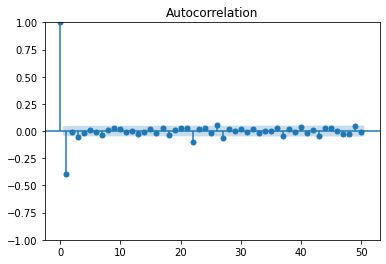

In [79]:
plot_acf(tot_train['memF'].diff().dropna(), lags=50, alpha=0.05);

In [80]:
# Space for futher analysis


# Understanding cross value lagged correlation
Using xcorr to get the idea of lagged dependency among variables

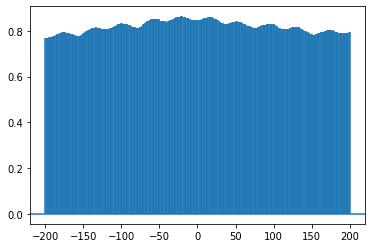

In [81]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['memF'].to_numpy()
plt.xcorr(x1,x2,normed=True,maxlags=200);

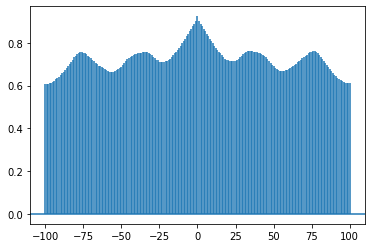

In [82]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,maxlags=100);

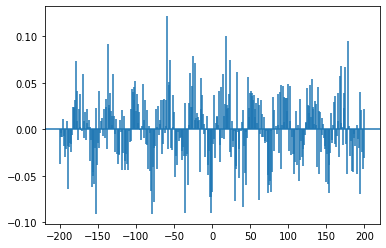

In [83]:
x1 = utilData['cpuScore'].diff().dropna().to_numpy()
x2 = utilData['memScore'].diff().dropna().to_numpy()
plt.xcorr(x1,x2,normed=True,usevlines=True,maxlags=200);

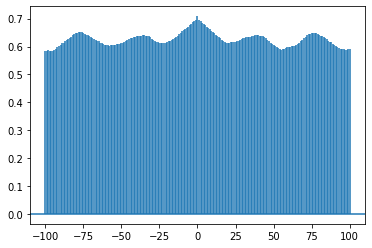

In [84]:
x1 = utilData['memF'].to_numpy()
x2 = utilData['memScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,maxlags=100);

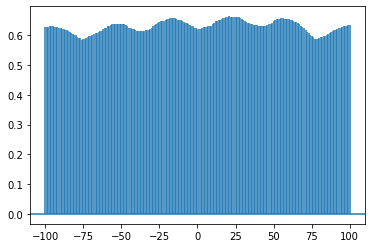

In [85]:
x1 = utilData['memF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,usevlines=True,maxlags=100);

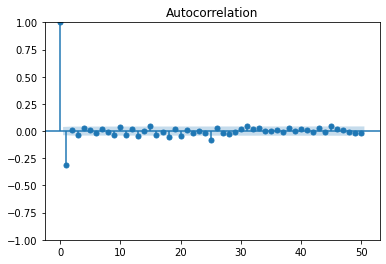

In [86]:
# from statsmodels.graphics.tsaplots import plot_acf
# fig, (ax1, ax2, ax3) = plt.subplots(3)
# plot_acf(utilData.cpuScore, ax=ax1,lags=50, alpha=0.05);
plot_acf(utilData.cpuload.diff().dropna(),lags=50, alpha=0.05);
# plot_acf(utilData.cpuload.diff().diff().dropna(),lags=50, alpha=0.05);


# Stationarity Check
We check whether a given variable is stationary

In [87]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(utilData['cpuload'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.452318
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [88]:
# Space for further checks

# Clustered Model approach

In [89]:
################################
## model
##
nr_sample = 2000
train = utilData.iloc[0:nr_sample]
test  = utilData.iloc[nr_sample:]

nr_chunk_sample = 50            # number of samples in a chunk
nr_chunk = int(nr_sample / nr_chunk_sample) # number of chunks
chunk_model = []                # which model chunk_model[i] belongs to

nr_model = 7                    # number of models
nr_model_switch_padding = 20    # number of padding samples between model switch
models = []

nr_kmean_epoch = 60             # number of epoch in k-mean
pr_kmean_update = 0.5           # learning rate of k-mean

#model_order = (2, 0, [2])
model_order = (3, 1, 1)
endog_key = 'cpuload'
exog_key = 'cpuF'


def diff(series):   # difference operation
    res = []
    for t in range(len(series)-1):
        if np.isnan(series[t]) or np.isnan(series[t+1]):
            res.append(0)
        else:
            res.append(series[t+1] - series[t])
    return res


def accu(series):   # accumulation operation
    res = []
    tsum = 0
    for t in (range(len(series))):
        tsum = tsum + series[t]
        res.append(tsum)
    return res


def get_sample(m):  # get sample for model m
    y, x = [], []
    for i in range(nr_chunk):
        # copy sample
        if chunk_model[i] != m:
            continue
        j = i + 1   # find the last contiguous mode
        while j < nr_chunk and chunk_model[j] == m:
            j = j + 1
        for k in range(i*nr_chunk_sample, j*nr_chunk_sample):
            y.append(train.loc[k, endog_key]) 
            x.append(train.loc[k, exog_key ])

        # padding
        if j + 1 >= nr_chunk:
            continue
        for k in range(nr_model_switch_padding):
            y.append(np.nan)
            x.append(np.nan)
            #x.append(x[-1]) # find a better value 
    return y, x


def fit_models():
    for m in range(nr_model):
        y, x = get_sample(m)
        y = diff(y) # length of y will by decreated by 1
        #x.pop()     # to mathch the length of x and y
        x = diff(x)
        if len(y) < nr_chunk_sample:
            continue
        #model = ARIMA(y, order=model_order).fit()
        model = ARIMA(y, order=model_order, exog=x).fit()
        models.append(model)
        print('mse', model.mse)


def init_chunks():
    for m in range(nr_chunk):
        chunk_model.append(random.randrange(nr_model))


def update_chunks():
    for c in range(nr_chunk):
        if random.random() > pr_kmean_update: # update slowly
            continue

        mses = []
        for m in range(nr_model):
            start, end = c*nr_chunk_sample, (c+1)*nr_chunk_sample
            y = list(train[endog_key][start:end])
            x = list(train[exog_key ][start:end])
            y = diff(y) # length of y will by decreated by 1
            #x.pop()     # to mathch the length of x and y
            x = diff(x)
            #res = models[m].apply(y, refit=False)
            res = models[m].apply(y, exog=x, refit=False)
            mses.append(res.mse)
        best = np.argmin(mses)
        chunk_model[c] = best


def estimate_models():
    # k-mean
    random.seed(1)
    init_chunks()
    for i in range(nr_kmean_epoch):
        print('[', i, '/', nr_kmean_epoch, ']--------------')
        fit_models()
        update_chunks()

def summary_models():
    for i in range(nr_model):
        print("Model Num: ", i)
        print(models[i].summary())



In [90]:
# estimate_models()


In [91]:
# summary_models()

# CPU Load prediction: Clustered approach

## 1. Fuzzy C mean clustering

In [92]:
import skfda
from skfda.ml.clustering import FuzzyCMeans, KMeans

In [93]:
N_Cluster = 2

In [94]:
dy = utilData.cpuload.diff().dropna().to_numpy()
dz = utilData.memLoad.diff().dropna().to_numpy()
dx = utilData.cpuScore.diff().dropna().to_numpy()

In [95]:
dz.shape,dx.shape

((2673,), (2673,))

In [96]:
min(dz)

-71.19718239883238

In [97]:
grid_point = [0,1,2]

In [98]:
data_matrix = []
for v in zip(dy,dz,dx):
    data_matrix.append([round(v[0],2),round(v[0],2)])

In [99]:
# data_matrix
data_matrix1 = []
for v in zip(dy,dz,dx):
    data_matrix1.append([round(v[0],1),round(v[1],2),round(v[2],2)])

In [100]:
# Test something

In [101]:
np.array(data_matrix1)      

array([[-27.  , -10.76, -12.71],
       [  4.  ,   7.09,   0.57],
       [  1.  ,  -0.  ,   0.79],
       ...,
       [ -3.  ,  -4.29,  -0.64],
       [  1.  ,   0.  ,   0.21],
       [  2.  ,   0.66,   0.43]])

In [102]:
fuzzy_kmeans = FuzzyCMeans(n_clusters=N_Cluster,n_init=5 ,random_state=0,fuzzifier=2,max_iter=400)

In [103]:
# fd = skfda.FDataGrid(data_matrix,grid_point)

In [104]:
# fuzzy_kmeans.fit(fd)

In [105]:
fd1 = skfda.FDataGrid(data_matrix1,grid_point)

In [106]:
fuzzy_kmeans.fit(fd1)

FuzzyCMeans(max_iter=400, n_init=5)

In [107]:
fuzzy_kmeans.cluster_centers_


FDataGrid(
    array([[[ 3.20071656],
            [-0.57896637],
            [ 2.02066826]],
    
           [[-3.11929999],
            [ 0.55046571],
            [-1.96219104]]]),
    grid_points=(array([0., 1., 2.]),),
    domain_range=((0.0, 2.0),),
    dataset_name=None,
    argument_names=(None,),
    coordinate_names=(None,),
    extrapolation=None,
    interpolation=SplineInterpolation(interpolation_order=1, monotone=False))

In [108]:
fuzzy_kmeans1 = FuzzyCMeans(n_clusters=N_Cluster,n_init=5 ,init=None,fuzzifier=2,max_iter=400,random_state=0)

In [109]:
fuzzy_kmeans1.fit(fd1)

FuzzyCMeans(max_iter=400, n_init=5)

In [110]:
fuzzy_kmeans1.cluster_centers_.data_matrix

array([[[ 3.20071656],
        [-0.57896637],
        [ 2.02066826]],

       [[-3.11929999],
        [ 0.55046571],
        [-1.96219104]]])

In [111]:
fuzzy_kmeans.labels_

array([1, 1, 0, ..., 1, 0, 0])

In [112]:
mem = fuzzy_kmeans.predict(fd1)
mem

array([1, 1, 0, ..., 1, 0, 0])

In [113]:
# utilData.iloc[201:221].cpufreq
# fd[0]

In [114]:
prob_count=fuzzy_kmeans.predict_proba(fd1) 

In [115]:
# prob_count

### Getting Conditional Probability

In [116]:
# Calculate transition
Count = [0 for _ in range(N_Cluster)]
TP_count = [[0 for _ in range(N_Cluster)] for _ in range(N_Cluster)]
for i in range(len(mem)):
    Count[mem[i]] += 1
    if i>0:
        TP_count[mem[i-1]][mem[i]] += 1

TP_count

[[455, 745], [746, 726]]

In [117]:
Cond_Prob = [[0 for _ in range(N_Cluster)] for _ in range(N_Cluster)]
for i in range(N_Cluster):
    for j in range(N_Cluster):
        Cond_Prob[i][j] = round(TP_count[i][j]/Count[j],3)
Cond_Prob

[[0.379, 0.506], [0.621, 0.493]]

In [118]:
#Caclulate fuzzy transition
PCount = [0 for _ in range(N_Cluster)]
PTP_count = [[0 for _ in range(N_Cluster)] for _ in range(N_Cluster)]
for i in range(len(prob_count)):
    for c in range(N_Cluster):
        PCount[c] += prob_count[i][c]
        if i>0:
            for cn in range(N_Cluster):
                PTP_count[cn][c] += prob_count[i-1][cn]*prob_count[i][c]



In [119]:
PCond_Prob = [[0 for _ in range(N_Cluster)] for _ in range(N_Cluster)]
for i in range(N_Cluster):
    for j in range(N_Cluster):
        PCond_Prob[i][j] = round(PTP_count[i][j]/PCount[j],3)
PCond_Prob

[[0.466, 0.521], [0.533, 0.479]]

In [120]:
mem = list(mem)

In [121]:
for i in range(N_Cluster):
    print(i," --> ", mem.count(i))

0  -->  1201
1  -->  1472


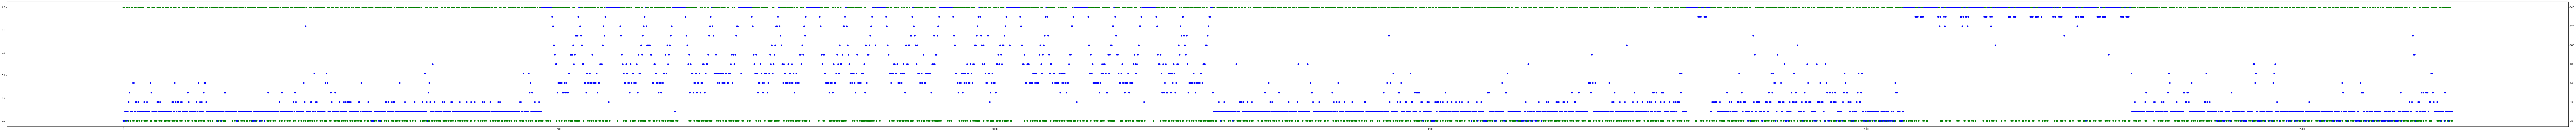

In [122]:
#Plot

fig, ax1 = plt.subplots(figsize=(200,10))

x = list(range(len(mem)))
y1 = mem
y2 = utilData['cpuF'].iloc[1:]
ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

In [123]:
# test comment

# Complete Architecture



Implementing the complete steps for the analysis and desing of our model


In [124]:
# Get the clustering model
import skfda
from skfda.ml.clustering import FuzzyCMeans, KMeans
import statsmodels.api as sm
# Num_Cluster = 4
# # Data for clustering
# dCpu = utilData.cpuload.diff().dropna().to_numpy()
# dMem = utilData.memLoad.diff().dropna().to_numpy()
# DataGrid for clustering

def getFDataGrid(inp):
    inp = np.array(inp)
    n_dim = inp.ndim
    if n_dim == 1:
        grid_point = list(range(len(inp)))
        data_grid = []
        data_grid.append(inp)
        fd = skfda.FDataGrid(data_grid,grid_point)
        return fd
    elif n_dim == 2:
        grid_point = list(range(len(inp[0])))
        data_grid = []
        for i in range(len(inp)):
            data_grid.append(inp[i])
        
        fd = skfda.FDataGrid(data_grid,grid_point)
        return fd
    else:
        raise Exception("Cannot handle more than 2 dimension for now") 
        return None
    
def getClusterModel(data,n_cluster=5,init_cluster=None):    
    fD = getFDataGrid(data)
    if fD == None:
        print("No data to cluster")
        return None
    fuzzyModel = FuzzyCMeans(n_clusters=n_cluster,n_init=5 ,init=init_cluster,fuzzifier=2,max_iter=400,random_state=0)
    fuzzyModel.fit(fD)
    return fuzzyModel
    
def get_C_prediction(model,data):
    fd = getFDataGrid(data)
    return model.predict_proba(fd)
    
def get_CondProb(model,data):
    prob_count = get_C_prediction(model,data)
    n_cluster = prob_count.shape[1]
    
    PCount = [0 for _ in range(n_cluster)]
    PTP_count = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
    for i in range(len(prob_count)):
        for c in range(n_cluster):
            PCount[c] += prob_count[i][c]
            if i>0:
                for cn in range(n_cluster):
                    PTP_count[cn][c] += prob_count[i-1][cn]*prob_count[i][c]
    
    
    PCond_Prob = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
    for i in range(n_cluster):
        for j in range(n_cluster):
            PCond_Prob[i][j] = round(PTP_count[i][j]/PCount[j],3)
    return PCond_Prob

def getShifted_Dataset(endog,p=1,exog=None,weight=None , shiftedExog=None):
    # Currently accepting only one dimensional exog if any
    if p < 1:
        print('Error needs atleast 1')
        return None
    plen = p
    df_temp = pd.DataFrame()
    df_temp['endog'] = endog
    # Getting shifted dataset
    for i in range(1,p+1):
        df_temp['Shift_endog_%d' % i] = df_temp['endog'].shift(i)
    if exog is not None:
        df_temp['exog'] = exog
        plen += 1
    if shiftedExog is not None:
        for i in range(1,shiftedExog+1):
            df_temp['Shift_exog_%d' % i] = df_temp['exog'].shift(i)
    if weight is not None:
        df_temp['Weight'] = weight
    elif weight is None:
        df_temp['Weight'] = np.ones(endog.shape[0])
        
    df_train_2 = df_temp.dropna()
    X_train = df_train_2.iloc[:,1:plen+1].values.reshape(-1,plen)
    y_train = df_train_2.iloc[:,0].values.reshape(-1)
    sample_weight = df_train_2['Weight'].values
    X_last = df_train_2.iloc[-1,:plen].values.reshape(-1,plen)
    return [y_train,X_train,X_last[0],sample_weight]

def WeighedLearn(y,X,weight):
    import statsmodels.api as sm
    X_sm = sm.add_constant(X)
    model = sm.WLS(y,X_sm,weights=weight)
    result = model.fit()
    return result

def ARPredict(model,y_last,steps=1,exog=None):
    # Ensure that the exog and model have the same dimension. Currently we have only one dim of exog
    if exog is not None:
        #Update
        if len(exog) != steps:
            print("Input variable incorrect")
            return None
    # Assume exog is there
    Y_out = []
    if exog is not None:
        X_update = []        
        X_inp = y_last
        for i in range(steps):
            X_test = [1.0]
#             X_test.extend(X_inp)
            X_test.append(exog[i])
            y_pred = model.get_prediction(X_test).predicted_mean
            Y_out.extend(y_pred)
            X_inp = y_pred+X_inp[:-1]
            print(X_inp)
        # Predict the data
        return Y_out
    else:
        #No exog
        X_inp = y_last
        for i in range(steps):
            X_test = [1.0]
            X_test.extend(X_inp)
            y_pred = model.get_prediction(X_test).predicted_mean
            Y_out.extend(y_pred)
            X_i = list(y_pred)
            X_i.extend(X_inp[:-1])
            X_inp = X_i
#             print(X_inp)
        return Y_out

In [125]:
def getNewDataFrame(fileName):
    myDf = pd.read_csv(fileName)
#     myDf['memLoad'] = myDf['memUse']*100/myDf['memTot']
    myDf['mUtil'] = myDf['mUtil'].clip(upper=100)
    myDf['mScore'] = myDf['mUtil']*myDf['mFreq']/825000000
    myDf['memF'] = myDf['mFreq']*100/825000000
    myDf['bcScore'] = myDf['bUtil']*myDf['bFreq']/1400000
#     myDf['cpuF'] = myDf['cpufreq']*100/1000000
    return myDf

utilData = getNewDataFrame('./UtilTestFinal')

In [126]:
#Testing new modification 
# 1. Download the data
mEndog = utilData.bUtil.to_numpy()
mExog = utilData.mUtil.to_numpy()
mDexog = utilData.mUtil.diff().to_numpy()
print(mEndog.shape,mExog.shape,mDexog.shape)

(8560,) (8560,) (8560,)


In [127]:
tD = getShifted_Dataset(mEndog,5)

<Axes: >

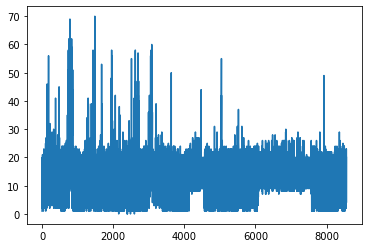

In [128]:
utilData.sUtil.plot()

In [129]:
import statsmodels.api as sm
def WeighedLearn(y,X,weight):
#     import statsmodels.api as sm
    X_sm = sm.add_constant(X)
    model = sm.WLS(y,X_sm,weights=weight)
    result = model.fit()
    return result

model = WeighedLearn(tD[0],tD[1],weight=tD[3])

In [130]:
X_test = sm.add_constant(tD[1])

In [131]:
y_act = tD[0]
y_pred = model.get_prediction(X_test).predicted_mean
df_c = pd.DataFrame()
df_c['predict'] = y_pred
df_c['act'] = y_act

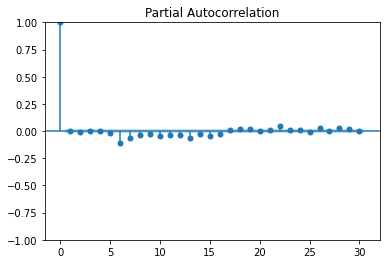

In [132]:
df_c['res'] = df_c.act - df_c.predict
myAr = df_c['res'].values
# myAr.shape
plot_pacf(myAr, lags=30, alpha=0.05,method='ols');

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     32.95
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           2.79e-33
Time:                        10:57:32   Log-Likelihood:                -23958.
No. Observations:                6000   AIC:                         4.793e+04
Df Residuals:                    5994   BIC:                         4.797e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4455      0.170     -2.625      0.009      -0.778      -0.113
x1            -0.1255      0.013     -9.850      0.000      -0.151      -0.101
x2            -0.0774      0.013     -6.077      0.000      -0.102      -0.052
x3            -0.0435      0.013     -3.415      0.001      -0.069      -0.019
x4            -0.0339      0.013     -2.657      0.008      -0.059      -0.009
x5            -0.0508      0.013     -3.990      0.000      -0.076      -0.026
==============================================================================
Omnibus:                     1062.849   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14042.873
Skew:                           0.446   Prob(JB):                         0.00
Kurtosis:                      10.442   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

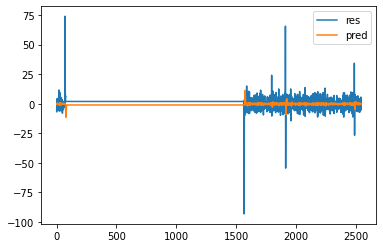

In [133]:
def MA(q,res):
    df_res = pd.DataFrame()
    df_res['res'] = res
#     print(df_res)
    for i in range(1,q+1):
        df_res['Shifted_%d' % i] = df_res['res'].shift(5+i)
    
#     print(df_res)
    my_data = df_res.dropna()
    my_train = pd.DataFrame(my_data[0:6000])
    my_test = pd.DataFrame(my_data[6000:])
#     print(my_train)
    X_train = my_train.iloc[:,1:].values.reshape(-1,q)
    X_sm = sm.add_constant(X_train)
#     print(X_train)
    Y_train = my_train.iloc[:,0].values.reshape(-1,1)
#     print(X_sm)
#     weight = np.ones(Y_train.shape[0])

    model = sm.OLS(Y_train,X_sm)
    result = model.fit()
    X_test = my_test.iloc[:,1:].values.reshape(-1,q)
    X_f = sm.add_constant(X_test)
    Y_f = my_test.iloc[:,0].values.reshape(-1)
    y_pred = result.get_prediction(X_f).predicted_mean
#     print(y_pred)
    df_plot = pd.DataFrame()
    df_plot['res'] = Y_f
    df_plot['pred'] = y_pred
    df_plot[['res','pred']].plot()
    return result

mymodel = MA(5,myAr)


# Get the 
mymodel.summary()    

<Axes: ylabel='Density'>

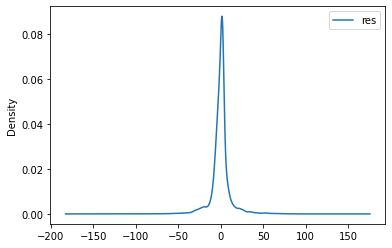

In [134]:
df_c[['res']].plot(kind='kde')

<Axes: >

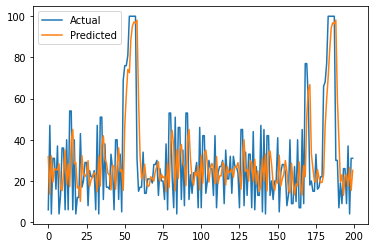

In [135]:
df_plot = pd.DataFrame()
df_plot['Actual'] = y_act[2000:2200]
df_plot['Predicted'] = y_pred[2000:2200]
df_plot[['Actual','Predicted']].plot()

In [136]:
import skfda
from skfda.ml.clustering import FuzzyCMeans, KMeans
class FuzzyCluster:
    def __init__(self,data,n_cluster=3,init_cluster=None,fuzzifier=2):
        self.data = data
        self.nclust = n_cluster
        self.init_clust = init_cluster
        self.model = None
        self.predictClus = None
        self.fData = None
        self.fuzzifier=fuzzifier
        self.probCond = None
    
    def getFDataGrid(self, inp):
        inp = np.array(inp)
        n_dim = inp.ndim
        if n_dim == 1:
            grid_point = list(range(len(inp)))
            data_grid = []
            data_grid.append(inp)
            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        elif n_dim == 2:
            grid_point = list(range(len(inp[0])))
            data_grid = []
            for i in range(len(inp)):
                data_grid.append(inp[i])

            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        else:
            raise Exception("Cannot handle more than 2 dimension for now") 
            return None
    
    def update_data(self,data):
        self.data.extend(data)
        return
        
        
    def fit(self):    
        self.fData = self.getFDataGrid(self.data)
        if self.fData == None:
            print("No data to cluster")
            return None
        self.model = FuzzyCMeans(n_clusters=self.nclust,n_init=5 ,init=self.init_clust,fuzzifier=self.fuzzifier,max_iter=400,random_state=0)
        self.model.fit(self.fData)
        self.predictClus = self.model.predict_proba(self.fData)
        return self.model,self.predictClus
    
    def predict_clust(self,data):
        fd = self.getFDataGrid(data)
        return self.model.predict_proba(fd)
    
    def get_center(self):
        return self.model.cluster_centers_.data_matrix
        
    def get_CondProb(self):
        prob_count = self.predictClus
        n_cluster = self.nclust

        PCount = [0 for _ in range(n_cluster)]
        PTP_count = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(len(prob_count)):
            for c in range(n_cluster):
                PCount[c] += prob_count[i][c]
                if i>0:
                    for cn in range(n_cluster):
                        PTP_count[cn][c] += prob_count[i-1][cn]*prob_count[i][c]


        self.probCond = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(n_cluster):
            for j in range(n_cluster):
                self.probCond[i][j] = round(PTP_count[i][j]/PCount[j],3)
        return self.probCond
    

        

In [137]:
MyClust = FuzzyCluster(data_matrix,2)

In [138]:
MyClust.fit()

(FuzzyCMeans(max_iter=400, n_init=5),
 array([[0.7896622 , 0.2103378 ],
        [0.00953677, 0.99046323],
        [0.01265999, 0.98734001],
        ...,
        [0.27714582, 0.72285418],
        [0.01265999, 0.98734001],
        [0.00105981, 0.99894019]]))

In [139]:
MyClust.predict_clust([-2,-2])

array([[0.17088542, 0.82911458]])

In [140]:
MyClust.get_CondProb()

[[0.285, 0.21], [0.713, 0.79]]

In [141]:
dCpu = utilData.bUtil.diff().dropna().to_numpy()
dMem = utilData.mUtil.diff().dropna().to_numpy()
# Create a combined Data
dM = []
for v in zip(dCpu,dMem):
    dM.append([round(v[0],1),round(v[1],2)])
myModel = getClusterModel(dM)
# get_C_prediction(myModel,dM)[:,0]
dCpu[-5:]

array([ 1., -4.,  8., -4., -4.])

In [142]:
Out = getShifted_Dataset(dCpu,5)
Model = WeighedLearn(Out[0],Out[1],weight=Out[3])
ARPredict(Model,Out[2],5)
# Model.summary()
print(Out[2])

[-4. -4.  8. -4.  1.]


In [143]:
dCpu[-1:-6:-1]

array([-4., -4.,  8., -4.,  1.])

In [144]:
model_verify = ARIMA(mEndog[:2500], order=(5,0,0),exog=dMem[:2500])

In [145]:
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.172
Model:                            WLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     355.5
Date:                Thu, 14 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:57:33   Log-Likelihood:                -32995.
No. Observations:                8554   AIC:                         6.600e+04
Df Residuals:                    8548   BIC:                         6.604e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.124     -0.002      0.999      -0.243       0.243
x1            -0.4392      0.011    -40.617      0.000      -0.460      -0.418
x2            -0.1596      0.012    -13.541      0.000      -0.183      -0.136
x3            -0.0372      0.012     -3.122      0.002      -0.060      -0.014
x4            -0.0736      0.012     -6.245      0.000      -0.097      -0.050
x5             0.0237      0.011      2.194      0.028       0.003       0.045
==============================================================================
Omnibus:                     1721.048   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56396.188
Skew:                           0.143   Prob(JB):                         0.00
Kurtosis:                      15.576   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
result_verify = model_verify.fit()
print(result_verify.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2500
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -10520.935
Date:                Thu, 14 Sep 2023   AIC                          21057.870
Time:                        10:57:33   BIC                          21104.462
Sample:                             0   HQIC                         21074.785
                               - 2500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.7082      1.948     14.225      0.000      23.890      31.526
x1             0.1600      0.023      6.865      0.000       0.114       0.206
ar.L1          0.4174      0.014     29.574      0.0

In [147]:
result_verify.forecast(steps=4,exog=dMem[2500:2504])

array([24.20102479, 20.68210121, 24.99271418, 24.60234454])

In [148]:
class ARMA:
    def __init__(self,endog,p=3,q=2,exog=None,weight=None):
        self.endog = endog
        self.p = p
        self.q = q
        self.exog = exog
        self.w = weight
        self.model = None
        self.MAmodel = None
        self.xData = None
        self.yData = None
        self.ylast = None
        self.fitData = None
        self.residual = None
        self.reslast = None
        
    def getShifted_Dataset(self):
        # Currently accepting only one dimensional exog if any
        if self.p < 1:
            print('Error needs atleast 1')
            return None
        plen = self.p
        df_temp = pd.DataFrame()
        df_temp['endog'] = self.endog
        # Getting shifted dataset
        for i in range(1,self.p+1):
            df_temp['Shift_endog_%d' % i] = df_temp['endog'].shift(i)
        if self.exog is not None:
            # We are assuming that the xvalues are 2D value
            self.exog = np.array(self.exog)
            for xid in range(self.exog.shape[0]):
                df_temp['exog_%d' % xid] = self.exog[xid]
                plen += 1
        if self.w is not None:
            df_temp['Weight'] = self.w
        elif self.w is None:
            df_temp['Weight'] = np.ones(self.endog.shape[0])

        df_train_2 = df_temp.dropna()
        X_train = df_train_2.iloc[:,1:plen+1].values.reshape(-1,plen)
        y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
        sample_weight = df_train_2['Weight'].values
        X_last = df_train_2.iloc[-1,:self.p].values.reshape(-1,self.p)
        return [y_train,X_train,X_last[0],sample_weight]
    
    def update_data(self,endog,exog=None,weight=None):
        # Addpending the data
        self.endog.extend(endog)
        if exog is not None:
            self.exog.extend(exog)
        if weight is not None:
            self.w.exend(weight)
        # This part is helps adding the new observed data and can be used to retrain the model
        self.ylast = self.endog[-1:-(self.p+1):-1]
        return
    
    def WeighedLearn(self,y,X,weight):
        import statsmodels.api as sm
        X_sm = sm.add_constant(X)
        model = sm.WLS(y,X_sm,weights=weight)
        result = model.fit()
        return result
    
    def AR(self):
        tData = self.getShifted_Dataset()
#         self.yData = tData[0]
#         self.xData = tData[1]
        self.ylast = tData[2]
#         weight = tData[3]
        self.model = self.WeighedLearn(tData[0],tData[1],weight=tData[3])
        # Get the residuals:
        return self.model,self.ylast
    
    def MA(self):
        df_res = pd.DataFrame()
        df_res['res'] = res
        #     print(df_res)
        for i in range(1,q+1):
            df_res['Shifted_%d' % i] = df_res['res'].shift(i)

        #     print(df_res)
        my_data = df_res.dropna()
        my_train = pd.DataFrame(my_data[0:6000])
        my_test = pd.DataFrame(my_data[6000:])
        #     print(my_train)
        X_train = my_train.iloc[:,1:].values.reshape(-1,q)
        X_sm = sm.add_constant(X_train)
        #     print(X_train)
        Y_train = my_train.iloc[:,0].values.reshape(-1,1)
        #     print(X_sm)
        #     weight = np.ones(Y_train.shape[0])

        model = sm.OLS(Y_train,X_sm)
        result = model.fit()
        X_test = my_test.iloc[:,1:].values.reshape(-1,q)
        X_f = sm.add_constant(X_test)
        Y_f = my_test.iloc[:,0].values.reshape(-1)
        y_pred = result.get_prediction(X_f).predicted_mean
        #     print(y_pred)
        df_plot = pd.DataFrame()
        df_plot['res'] = Y_f
        df_plot['pred'] = y_pred
        df_plot[['res','pred']].plot()
        return result
           
    def get_predict(self,steps=1,exog=None):
        # Ensure that the exog and model have the same dimension. Currently we have only one dim of exog
        if exog is not None:
            #Update
            if len(exog) != steps:
                print("Exog variable incorrect")
                return None
        # Assume exog is there
        Y_out = []
#         print("exog",exog)
        if exog is not None:
            X_update = []        
            X_inp = self.ylast
#             print("ylast",self.ylast)
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                X_test.extend(exog[i])
#                 print("Xtest",X_test)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
#                 print(X_inp)
            # Predict the data
            return Y_out
        else:
            #No exog
            X_inp = self.ylast
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
    #             print(X_inp)
            return Y_out        

In [149]:
weight = np.linspace(0.5,1.0,2500)
classTest = ARMA(mEndog[:2500],p=5,exog=[mExog[:2500],mDexog[:2500]],weight=weight)
classTest.AR()
# classTest.get_predict(steps=3,exog=dMem[2500:2503])

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fad689d9cd0>,
 array([27.,  4., 45.,  7., 35.]))

In [150]:
mDexog[2500]

6.0

In [151]:
classTest.get_predict(steps=1,exog=[[mExog[2500],mDexog[2500]]])

[23.25678888961429]

In [152]:
len(dMem)

8559

In [153]:
X = [1,2,3]
Y = [4,5]
X.extend(Y)
print(X)

[1, 2, 3, 4, 5]


In [154]:
import numpy as np
X = np.array([[1,2,3],[3,2,3]])


# Modular Code
Here we will use the classes to actually create the pipeline for our estimation

In [155]:
import skfda
from skfda.ml.clustering import FuzzyCMeans, KMeans
class OSLFuzzyCluster:
    def __init__(self,data,n_cluster=3,init_cluster=None,fuzzifier=2):
        self.data = data
        self.nclust = n_cluster
        self.init_clust = init_cluster
        self.model = None
        self.predictClus = None
        self.fData = None
        self.fuzzifier=fuzzifier
        self.probCond = None
    
    def getFDataGrid(self, inp):
        inp = np.array(inp)
        n_dim = inp.ndim
        if n_dim == 1:
            grid_point = list(range(len(inp)))
            data_grid = []
            data_grid.append(inp)
            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        elif n_dim == 2:
            grid_point = list(range(len(inp[0])))
            data_grid = []
            for i in range(len(inp)):
                data_grid.append(inp[i])

            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        else:
            raise Exception("Cannot handle more than 2 dimension for now") 
            return None
    
    def update_data(self,data):
        self.data = np.append(self.data,np.array(data))
        return
        
        
    def fit(self):    
        self.fData = self.getFDataGrid(self.data)
        if self.fData == None:
            print("No data to cluster")
            return None
        self.model = FuzzyCMeans(n_clusters=self.nclust,n_init=5 ,init=self.init_clust,fuzzifier=self.fuzzifier,max_iter=400,random_state=0)
        self.model.fit(self.fData)
        self.predictClus = self.model.predict_proba(self.fData)
        return self.model,self.predictClus
    
    def predict_clust(self,data):
        fd = self.getFDataGrid(data)
        return self.model.predict_proba(fd)
    
    def get_center(self):
        return self.model.cluster_centers_.data_matrix
        
    def get_CondProb(self):
        prob_count = self.predictClus
        n_cluster = self.nclust

        PCount = [0 for _ in range(n_cluster)]
        PTP_count = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(len(prob_count)):
            for c in range(n_cluster):
                PCount[c] += prob_count[i][c]
                if i>0:
                    for cn in range(n_cluster):
                        PTP_count[cn][c] += prob_count[i-1][cn]*prob_count[i][c]


        self.probCond = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(n_cluster):
            for j in range(n_cluster):
                self.probCond[i][j] = round(PTP_count[i][j]/PCount[i],3) # P(Y(t) in j / Y(t-1) in i)
        return self.probCond
    

        

In [156]:
class OSLARMA:
    def __init__(self,endog,p=3,exog=None,weight=None):
        self.endog = endog
        self.p = p
        self.exog = exog
        self.w = weight
        self.model = None
        self.xData = None
        self.yData = None
        self.ylast = None
        self.fitData = None
    
    def summary(self):
        return self.model.summary()
        
    def getShifted_Dataset(self):
        # Currently accepting only one dimensional exog if any
        if self.p < 1:
            print('Error needs atleast 1')
            return None
        plen = self.p
        df_temp = pd.DataFrame()
        df_temp['endog'] = self.endog
        # Getting shifted dataset
        for i in range(1,self.p+1):
            df_temp['Shift_endog_%d' % i] = df_temp['endog'].shift(i)
        if self.exog is not None:
            df_temp['exog'] = self.exog
            plen += 1
        if self.w is not None:
            df_temp['Weight'] = self.w
        elif self.w is None:
            df_temp['Weight'] = np.ones(self.endog.shape[0])

        df_train_2 = df_temp.dropna()
        X_train = df_train_2.iloc[:,1:plen+1].values.reshape(-1,plen)
        y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
        sample_weight = df_train_2['Weight'].values
        X_last = df_train_2.iloc[-1,:self.p].values.reshape(-1,self.p)
        return [y_train,X_train,X_last[0],sample_weight]
    
    def update_data(self,endog,exog=None,weight=None):
        # Addpending the data
        self.endog = np.concatenate((self.endog,np.array(endog)))
        
        if exog is not None:
            self.exog = np.concatenate((self.exog, np.array(exog)))
        if weight is not None:
            self.w = np.concatenate((self.w,np.array(weight)))
        # This part is helps adding the new observed data and can be used to retrain the model
        self.ylast = self.endog[-1:-(self.p+1):-1]
#         #Test Code
#         print("Update",self.ylast)
#         #End testcode
        return
    
    def WeighedLearn(self,y,X,weight):
        import statsmodels.api as sm
        X_sm = sm.add_constant(X)
        model = sm.WLS(y,X_sm,weights=weight)
        result = model.fit()
        return result
    
    def fit(self):
        tData = self.getShifted_Dataset()
#         self.yData = tData[0]
#         self.xData = tData[1]
        self.ylast = tData[2]
#         weight = tData[3]
        self.model = self.WeighedLearn(tData[0],tData[1],weight=tData[3])
        return self.model,self.ylast
           
    def get_predict(self,steps=1,exog=None):
        # Ensure that the exog and model have the same dimension. Currently we have only one dim of exog
        if exog is not None:
            #Update
            if len(exog) != steps:
                print("Exog variable incorrect")
                return None
        # Assume exog is there
        Y_out = []
#         print("exog",exog)
        if exog is not None:
            X_update = []        
            X_inp = self.ylast
#             print("ylast",self.ylast)
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                X_test.append(exog[i])
#                 print("Xtest",X_test)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
#                 print(X_inp)
            # Predict the data
            return Y_out
        else:
            #No exog
            X_inp = self.ylast
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
    #             print(X_inp)
            return Y_out        

In [157]:
def getDataFrame(fileName):
    myDf = pd.read_csv(fileName)
    myDf['memLoad'] = myDf['memUse']*100/myDf['memTot']
    myDf['memScore'] = myDf['memLoad']*myDf['memfreq']/825000000
    myDf['memF'] = myDf['memfreq']*100/825000000
    myDf['cpuScore'] = myDf['cpuload']*myDf['cpufreq']/1400000
    myDf['cpuF'] = myDf['cpufreq']*100/1000000
    return myDf

In [158]:
def getDataMatrix(dx,dy=None):
    data_matrix=[]
    if dy is None:
        for v in dx:
            data_matrix.append([round(v,2),round(v,2)])
    else:
        for v in zip(dx,dy):
            data_matrix.append([round(v[0],2),round(v[1],2)])
    return data_matrix


In [159]:
# Testing without exog
def main():
    utilData = getDataFrame('./Util_Run1.csv')
#     dy = utilData.cpuload.diff().dropna().to_numpy()
    dy = utilData.memLoad.dropna().to_numpy()
    nCluster = 5
    y_train = dy[:2000]
    y_test = dy[2000:]
    y_dmat = getDataMatrix(y_train)
    myClust = OSLFuzzyCluster(y_dmat,n_cluster=nCluster)
    _, data_weight = myClust.fit()
#     print(dy[0])
#     print(data_weight)
#     print("data_cluster", myClust.get_center())
    trans_prob = myClust.get_CondProb()
    print(trans_prob)
    print("\n\n\n")
    # We will send the weights of the data and then train these models
    models = []
    # Train the models
    for i in range(nCluster):
        model = OSLARMA(y_train,p=5,weight=data_weight[:,i])
        model.fit()
#         print(model.summary())
        models.append(model)
    
    # Models are trained now begin prediction
#     print("last actual value", y_train[-1],"Likelihood cluster", myClust.predict_clust([ y_train[-1], y_train[-1]]))
    y_prior = y_train[-1]
    for i in range(100):
        # Get prob of P(Y(t-1) in i) using cluster
        P_prior = myClust.predict_clust([y_prior,y_prior])[0]
#         print("P",P_prior)
        P_like = []
        # Predict likelihood of Y(t) in cluster based on transition prob
        for k in range(nCluster):
            prob = 0
            for j in range(nCluster):
                prob += trans_prob[j][k]*P_prior[j]
            P_like.append(prob)
        
#         print("PLike",P_like)
        y_act = y_test[i]
        y_prior = y_act
        y_pred = []
        y_est = 0
        for j in range(nCluster):
            y_pred.append(models[j].get_predict()[0])
            y_est += y_pred[-1]*P_like[j]
        
        print(i, y_act,y_est)
        
        for j in range(nCluster):
            models[j].update_data([y_act])
            

main()
    

[[0.56, 0.045, 0.017, 0.358, 0.018], [0.206, 0.392, 0.149, 0.18, 0.072], [0.045, 0.17, 0.505, 0.048, 0.232], [0.196, 0.022, 0.005, 0.771, 0.006], [0.029, 0.028, 0.092, 0.022, 0.829]]




0 4.6009927453226425 10.379401091834723
1 9.48373522802591 6.1755545659384605
2 5.557423297762445 9.740517912876141
3 5.557423297762445 6.84397581109295
4 7.116780678893555 6.799221055592176
5 6.947367601428032 8.561457509201908
6 7.018155467204607 8.435576383028172
7 9.152830572229112 8.44495740733975
8 2.596061148602121 9.696098360660262
9 3.400656856913807 5.413916754321308
10 2.7218970982687147 5.4260819099699615
11 1.9651488170948868 5.439957297550994
12 1.6681208193111472 5.362227476450483
13 13.083459368382908 5.2824948204925795
14 12.961468286556489 10.53029730375546
15 13.00181398286982 10.551097629357997
16 5.539533060011106 10.609637490001388
17 5.589252640229617 6.788818942388199
18 2.19219135888115 6.983626102591273
19 9.461207369028742 5.613682375255892
20 2.415083680531036 9.825713294938

In [160]:
import numpy as np

In [161]:
a = np.array([1,2,3])
b= np.array([3,2,1])
c = b-a
c

array([ 2,  0, -2])

In [162]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [163]:
X = [[1,3,5],[2,4,6]]
X = np.array(X)

X.shape

(2, 3)

In [164]:
X = np.concatenate((X,np.array([[7,8]]).reshape(X.shape[0],1)),axis=1)
X.ndim

2

# Filtering Data
Here we will test low-pass and high-pass filters

<Axes: >

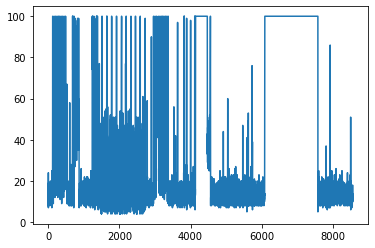

In [165]:
# Plot the data
# utilData['bUtil'].values.plot()

df_plot = pd.DataFrame()
df_plot['bUtil'] = utilData.bUtil.values
df_plot.bUtil.plot()

In [166]:
from scipy.signal import butter,filtfilt

In [167]:
T = 500
fs = 2.0
cutoff = 0.5
nyq = 0.5*fs
order = 2
n = int(T*fs)
data = df_plot.iloc[400:1400,:].bUtil.values


In [168]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [169]:
y = butter_lowpass_filter(data, cutoff, fs, order)

<Axes: >

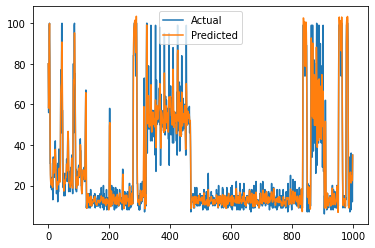

In [170]:
df_p = pd.DataFrame()
df_p['Actual'] = data
df_p['Predicted'] = y
df_p[['Actual','Predicted']].plot()

In [171]:
# Low 

In [172]:
from scipy.signal import lfilter
def butter_filter(data, cutoff, fs=2.0, order=2,passtype='low'):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype=passtype, analog=False)
    y = filtfilt(b, a, data)
    y = np.array(y)
    return y
def butter_lfilter(data, cutoff, fs=2.0, order=2,passtype='low'):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype=passtype, analog=False)
    y = lfilter(b, a, data)
    y = np.array(y)
    return y

<Axes: >

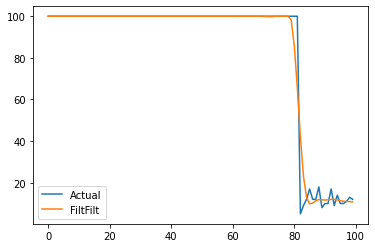

In [173]:
utilData = getNewDataFrame('./UtilTestFinal')
PASS='low'
df_raw = pd.DataFrame()
df_raw['endog'] = utilData.bUtil
dx = df_raw.endog.to_numpy()
dy = np.clip(butter_filter(df_raw.endog.to_numpy(),0.25,passtype=PASS),-100,100)
dz = np.clip(butter_lfilter(df_raw.endog.to_numpy(),0.25,passtype=PASS),-100,100)
df_plot = pd.DataFrame()
df_plot['Actual'] = dx[7500:7600]
df_plot['FiltFilt'] = dy[7500:7600]
df_plot['LFilter'] = dz[7500:7600]
# df_plot[['Actual','FiltFilt','LFilter']].plot()
df_plot[['Actual','FiltFilt']].plot()
# df_plot[['Actual','LFilter']].plot()
# df_plot[['FiltFilt','LFilter']].plot()

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: >

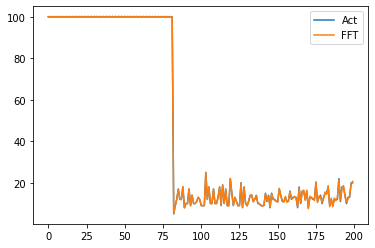

In [174]:
from scipy.fft import fft,ifft,fftfreq
# import random
# #Generate 5 random numbers between 10 and 30
# dx = np.random.rand(100,1)
# # print(randomlist)

mySig = dx[7000:7800]


N = len(mySig)
yfft = fft(mySig)
xf = fftfreq(N,1/100.0)
yfftN = yfft
yfftN[396:-395] = 0
# yfftN[1000:-1000] = 0
y_rec = ifft(yfftN)
df_fftpl = pd.DataFrame()
df_fftpl['Act'] = mySig[500:700]
df_fftpl['FFT'] = y_rec[500:700]
df_fftpl[['Act','FFT']].plot()
# df_fftpl['Act'].plot()
# plt.plot(xf[:20],np.abs(yfft)[:20])
# plt.grid()
# plt.show()

# yfft


In [175]:
len(dx)//2

4280

In [176]:
x = np.array([1,2,3,4,5,6,7,8,9,0])
x = np.append(x,7)
x

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 7])

# Window FFT ( Variable)

In [213]:
# Get data 
from scipy.fft import fft,ifft,fftfreq,irfft
utilData = getNewDataFrame('./UtilTestFinal')



def FFTPass(signal,passX=45,pType='low'):
    W = len(signal)
    yfft =fft(signal)
    if pType=='low':
#         yfft[0] = signal[-1]*W/2.0
        yfft[passX:W-passX] = 0
    elif pType=='high':
#         yfft[0] = signal[-1]*W/2.0
        yfft[:passX]=0
        yfft[W-passX:]=0
    fSig = ifft(yfft)
    return fSig.real

In [214]:
def FFTEnergy(signal):
    Sz = len(signal)
    yfft = fft(signal)
    yfft = np.sum(np.square(yfft.real)/Sz)
    return yfft
    

In [215]:
def windowFFT(signal,W=100,passX=45,pType='low'):
    if passX > W//2:
        passX = W//2
    lSig = len(signal)
    energy = []
    filtSig = FFTPass(signal[0:W],passX,pType)
    energy.append(FFTEnergy(signal[0:W]))
    for i in range(1,lSig-W+1):
        newSig = FFTPass(signal[i:i+W],passX,pType)[-1]
        energy.append(FFTEnergy(signal[i:i+W]))
        filtSig = np.append(filtSig,newSig)
    return filtSig, np.array(energy)
        

In [216]:
signal = utilData.bUtil.to_numpy()
hfilterSig,hEnergy = windowFFT(signal,W=100,passX=4,pType='high')
lfilterSig,lEnergy = windowFFT(signal,W=100,passX=4,pType='low')


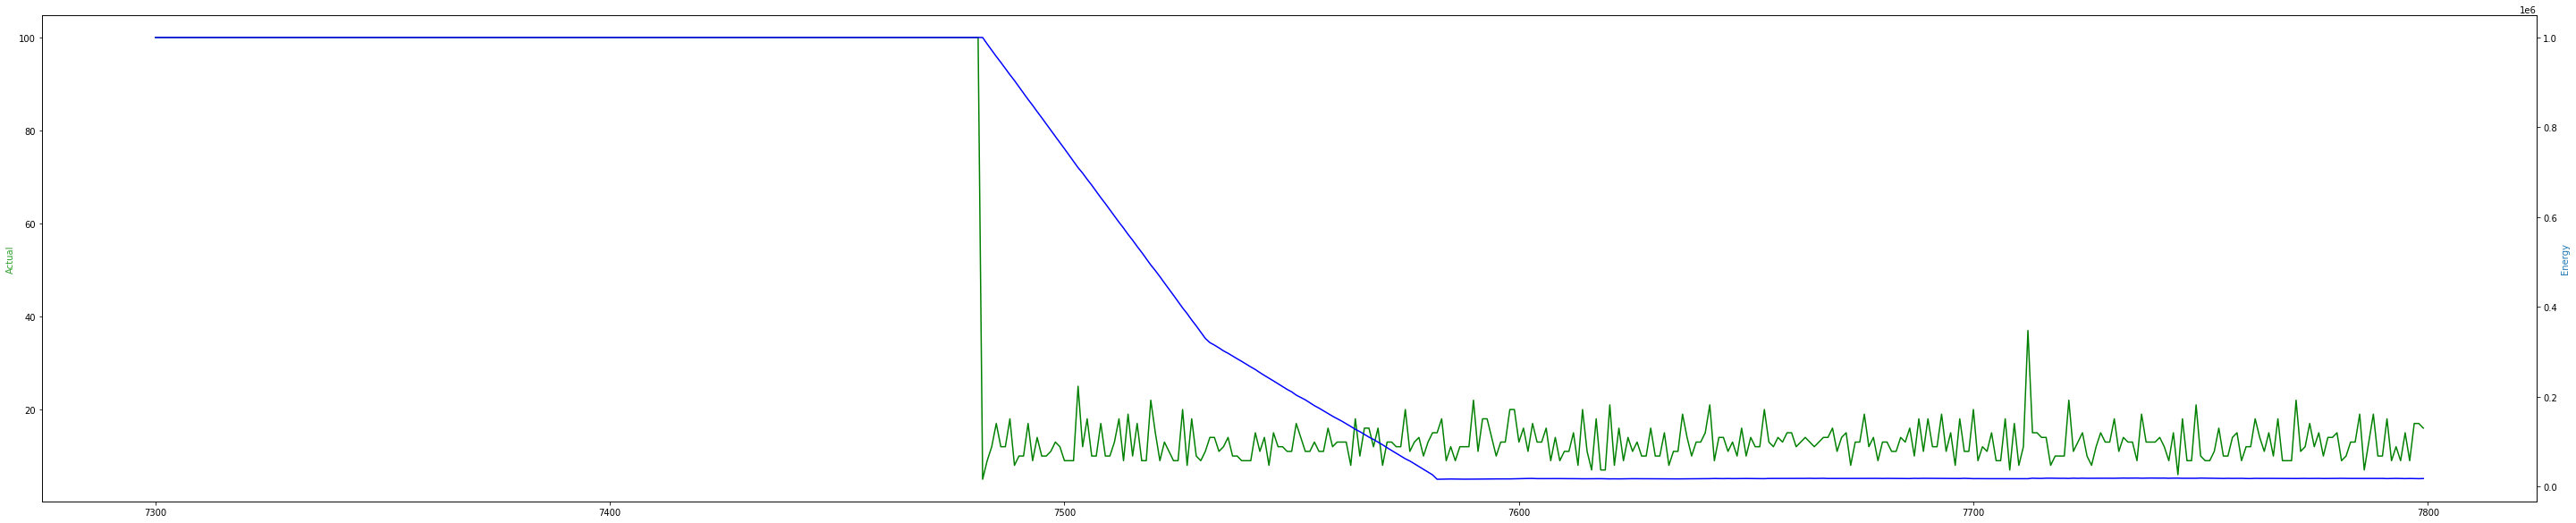

In [219]:

START,END,W=7300,7800,100
# print(utilData.bUtil.diff().shift(1))
fig, ax1 = plt.subplots(figsize=(50,10))

x = np.array(range(START,END))
y1 = signal[START+W:END+W]
y2 = hEnergy[START:END]


ax2 = ax1.twinx()

ax1.set_ylabel('Actual', color="tab:green")
ax1.plot(x, y1, 'g')
ax2.set_ylabel('Energy', color="tab:blue") 
ax2.plot(x, y2, 'b')


<Axes: >

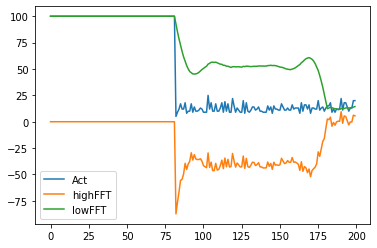

In [180]:
df_fftpl = pd.DataFrame()
START,END=7500,7700
df_fftpl['Act'] = signal[START:END]
df_fftpl['highFFT'] = hfilterSig[START:END]
df_fftpl['lowFFT'] = lfilterSig[START:END]
df_fftpl['combFFT'] = lfilterSig[START:END]+hfilterSig[START:END]

# df_fftpl[['Act','combFFT']].plot()
df_fftpl[['Act','highFFT','lowFFT']].plot()

[]


<Axes: >

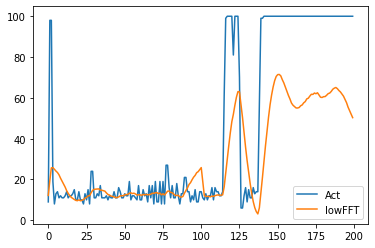

In [181]:
df_fftpl = pd.DataFrame()
START,END=4000,4200
df_fftpl['Act'] = signal[START:END]
df_fftpl['highFFT'] = hfilterSig[START:END]
df_fftpl['lowFFT'] = lfilterSig[START:END]
df_fftpl['combFFT'] = lfilterSig[START:END]+hfilterSig[START:END]
# 
# df_fftpl[['Act','combFFT']].plot()
print(df_fftpl['lowFFT'].iloc[200:202].values)
df_fftpl[['Act','lowFFT']].plot()

In [185]:
x = np.sum(np.square([1,2,3,4]))
x

30